DATA DOWNLOADED FROM: https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset

In [1]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.8 MB/s eta 0:00:0000:01


In [2]:
# Load the libraries
import torch
import torch.nn as nn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.parallel import DistributedDataParallel as DDP

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Set seed for the project
seed = 42
torch.manual_seed(seed)

**PREPARE DATASETS**

In [4]:
# Read the dataset (Reddit)
data_path_1 = '/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv'
df1 = pd.read_csv(data_path_1)
df1.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [5]:
# Read the dataset(Twitter)
data_path_2 = '/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv'
df2 = pd.read_csv(data_path_2)
df2 = df2.dropna()
df2['category'] = df2['category'].astype(int)
df2.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1


In [6]:
# Merge two datasets 
df2 = df2.rename(columns = {'clean_text': 'clean_comment'})
df = pd.concat([df1, df2], axis = 0)
# Fill any potential NaN values in 'clean_comment' with an empty string
df['clean_comment'] = df['clean_comment'].fillna('')
df = df[df['clean_comment'] != '']
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [7]:
# Re-label the labels
label_mapping = {-1: 0, 0: 1, 1: 2}
df['category'] = df['category'].map(label_mapping)

In [8]:
classes = {
    class_name: idx for idx, class_name in enumerate(df['category'].unique().tolist())
}
print(classes)

{2: 0, 0: 1, 1: 2}


**DATA PREPROCESSING**

In [9]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
    # Lowering the text
    text = text.lower()
    
    # Unicode
    text = unidecode.unidecode(text)

    # Remove white space
    text = text.strip()

    # Remove redundants
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stopwords
    text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])

    # Bring the words to their originals
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')])

    return text

In [10]:
# Apply to comments
df['clean_comment'] = df['clean_comment'].apply(lambda x: text_normalize(x))

In [11]:
vocab = set()
for sentence in df['clean_comment'].tolist():
    tokens = sentence.split()
    vocab.update(tokens)

vocab = list(vocab)
vocab.append('UNK')   # Unknown words
vocab.append('PAD')   # Padding
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

In [12]:
# Transform function
def transform(text, word_to_idx, max_seq_len):
    tokens = []
    for w in text.split():
        try:
            w_ids = word_to_idx[w]
        except:
            w_ids = word_to_idx['UNK']
        tokens.append(w_ids)

    # If length of tokens smaller than max_seq_len, add padding. 
    # Otherwise, keep its length as max_seq_len 
    if len(tokens) < max_seq_len:
        tokens += [word_to_idx['PAD']] * (max_seq_len - len(tokens))
    elif len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len]

    return tokens

In [13]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['clean_comment'].tolist()
labels = df['category'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

**PYTORCH DATASET**

In [14]:
class RedditTwitter(Dataset):
    def __init__(
        self,
        X, y,
        word_to_idx,
        max_seq_len,
        transform=None
    ):
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform
        
        # Store vocab_size and n_classes to check against
        self.vocab_size = len(word_to_idx)
        
        # Assuming you have n_classes defined globally or can pass it
        # We will define n_classes from the unique values in labels for robustness
        unique_labels = sorted(list(set(y)))
        self.n_classes = len(unique_labels)
        if unique_labels != list(range(self.n_classes)):
             print(f"Warning: Labels are not contiguous or do not start from 0. Found labels: {unique_labels}")


    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        if self.transform:
            text = self.transform(
                text,
                self.word_to_idx,
                self.max_seq_len
            )

        # Add a check to ensure indices are within vocab_size before converting to tensor
        if any(t >= self.vocab_size or t < 0 for t in text):
             print(f"Error: Invalid text index found in item {idx}. Indices: {text}")
             print(f"Vocab size: {self.vocab_size}")
             pass 

        # Convert text and label to tensors with appropriate data types
        text = torch.tensor(text, dtype=torch.long)
        label = torch.tensor(label, dtype=torch.long) # Ensure label dtype is long

        # Add an assertion to check if the label is within the valid range
        assert label < self.n_classes and label >= 0, f"Error: Label {label.item()} for item {idx} is out of valid range [0, {self.n_classes - 1}]"


        return text, label

In [15]:
max_seq_len = 32

# Train dataset
train_dataset = RedditTwitter(
    X_train, y_train,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

# Val dataset
val_dataset = RedditTwitter(
    X_val, y_val,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

# Test dataset
test_dataset = RedditTwitter(
    X_test, y_test,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

In [16]:
train_batch_size = 128
test_batch_size = 8

# Train loader
train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

# Val loader
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

# Test loader
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

**MODEL**

In [17]:
class SentimentClassifier(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim,
        hidden_size, n_layers, n_classes,
        dropout_prob
    ):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Bi-Directional LSEM
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, n_layers,
            batch_first=True, bidirectional = True
        )
        # Initialize LayerNorm with 2 * hidden_size as LSTM is 2 directions
        self.norm = nn.LayerNorm(hidden_size * 2)
        self.dropout = nn.Dropout(dropout_prob)
        
        self.fc1 = nn.Linear(hidden_size * 2, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [18]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model
model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob
).to(device)

# We utilize both GPU T4
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPU!")
    model = nn.DataParallel(model)

Using 2 GPU!


In [19]:
model.eval()

dummy_tensor = torch.randint(10, (1, 10)).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([1, 3])


**TRAINING**

In [20]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [21]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [22]:
lr = 1e-4
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [23]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 0.9999	Val loss: 0.9656
EPOCH 2:	Train loss: 0.9338	Val loss: 0.8892
EPOCH 3:	Train loss: 0.8320	Val loss: 0.8013
EPOCH 4:	Train loss: 0.7752	Val loss: 0.7686
EPOCH 5:	Train loss: 0.7417	Val loss: 0.7381
EPOCH 6:	Train loss: 0.7162	Val loss: 0.7234
EPOCH 7:	Train loss: 0.6927	Val loss: 0.7063
EPOCH 8:	Train loss: 0.6712	Val loss: 0.6920
EPOCH 9:	Train loss: 0.6490	Val loss: 0.6774
EPOCH 10:	Train loss: 0.6266	Val loss: 0.6555
EPOCH 11:	Train loss: 0.6014	Val loss: 0.6381
EPOCH 12:	Train loss: 0.5724	Val loss: 0.6159
EPOCH 13:	Train loss: 0.5442	Val loss: 0.5913
EPOCH 14:	Train loss: 0.5193	Val loss: 0.5923
EPOCH 15:	Train loss: 0.4988	Val loss: 0.5700
EPOCH 16:	Train loss: 0.4809	Val loss: 0.5590
EPOCH 17:	Train loss: 0.4622	Val loss: 0.5550
EPOCH 18:	Train loss: 0.4490	Val loss: 0.5579
EPOCH 19:	Train loss: 0.4352	Val loss: 0.5523
EPOCH 20:	Train loss: 0.4224	Val loss: 0.5568
EPOCH 21:	Train loss: 0.4105	Val loss: 0.5423
EPOCH 22:	Train loss: 0.3999	Val loss: 0.54

**PLOTTING LOSSES**

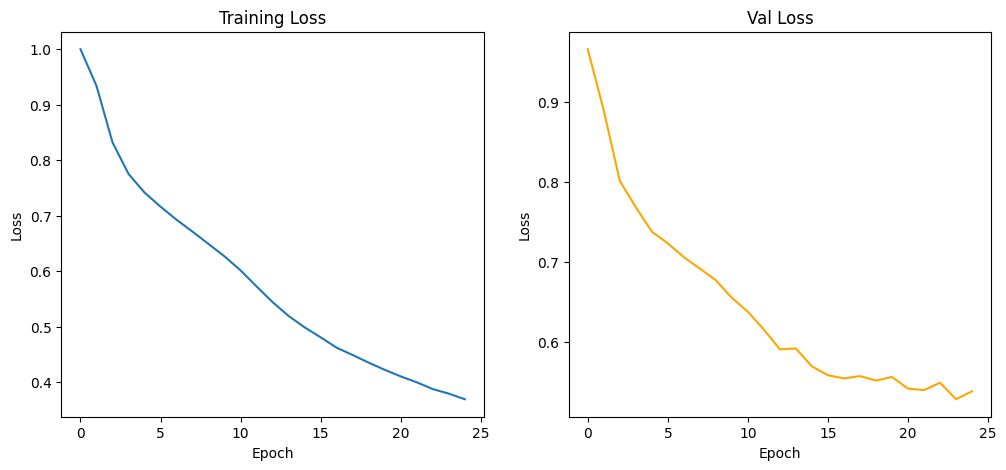

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

**EVALUATION**

In [25]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.8056915850489706
Test accuracy:  0.8069658205076954
